In [2]:
import pandas as pd

data = pd.read_csv('normalized_merged_data.csv')

In [3]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokeniza el texto
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['text'])

# Convierte el texto en secuencias numéricas
sequences = tokenizer.texts_to_sequences(data['text'])

# Rellena las secuencias para que tengan la misma longitud
max_sequence_length = 100  # Define la longitud máxima de las secuencias
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Normaliza los puntajes de contenido y redacción
scaler = MinMaxScaler()
data['normalized_content'] = scaler.fit_transform(data[['normalized_content']])
data['normalized_wording'] = scaler.fit_transform(data[['normalized_wording']])


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=max_sequence_length))
model.add(LSTM(64))
model.add(Dense(2, activation='sigmoid'))  # 2 neuronas para los puntajes de contenido y redacción

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, data[['normalized_content', 'normalized_wording']], test_size=0.2, random_state=42)

model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
180/180 [==============================] - 16s 75ms/step - loss: 0.0221 - mae: 0.1147 - val_loss: 0.0113 - val_mae: 0.0822
Epoch 2/20
180/180 [==============================] - 13s 72ms/step - loss: 0.0105 - mae: 0.0796 - val_loss: 0.0103 - val_mae: 0.0777
Epoch 3/20
180/180 [==============================] - 13s 72ms/step - loss: 0.0078 - mae: 0.0681 - val_loss: 0.0103 - val_mae: 0.0768
Epoch 4/20
180/180 [==============================] - 13s 72ms/step - loss: 0.0061 - mae: 0.0603 - val_loss: 0.0106 - val_mae: 0.0771
Epoch 5/20
180/180 [==============================] - 13s 72ms/step - loss: 0.0049 - mae: 0.0537 - val_loss: 0.0115 - val_mae: 0.0809
Epoch 6/20
180/180 [==============================] - 13s 72ms/step - loss: 0.0041 - mae: 0.0488 - val_loss: 0.0107 - val_mae: 0.0778
Epoch 7/20
180/180 [==============================] - 13s 72ms/step - loss: 0.0034 - mae: 0.0444 - val_loss: 0.0107 - val_mae: 0.0773
Epoch 8/20
180/180 [==============================] - 13s 72ms

In [7]:
def evaluate_summary(summary_text):
    # Preprocesa el texto del resumen
    summary_sequence = tokenizer.texts_to_sequences([summary_text])
    padded_summary = pad_sequences(summary_sequence, maxlen=max_sequence_length)

    # Realiza la predicción
    prediction = model.predict(padded_summary)

    # La predicción contendrá los puntajes de contenido y redacción
    return prediction[0]

# Ejemplo de evaluación
summary = "During the 1967 Third Wave experiment at Cubberley High School, students experienced a rapid transformation in their behavior and beliefs. The experiment aimed to demonstrate how easily people can be swayed to support authoritarian ideologies. Under the leadership of their teacher, Ron Jones, students adopted a strict code of conduct and authoritarian structure in a matter of days. They were highly engaged in this ""movement,"" even to the point of shutting out non-members and eagerly awaiting a televised announcement by a supposed presidential candidate from the movement. The experiment ended when Ron Jones felt it was spiraling out of control, illustrating the potential danger of such movements."
scores = evaluate_summary(summary)
print(f"Puntaje de contenido: {scores[0]}, Puntaje de redacción: {scores[1]}")


1/1 [==============================] - 0s 23ms/step
Puntaje de contenido: 0.6105629801750183, Puntaje de redacción: 0.6032240986824036


In [10]:
import pickle

# Guardar el modelo en un archivo
model.save('modelo_resumen.h5')

# Guardar el tokenizer en un archivo
with open('tokenizer.pickle', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - 1s 15ms/step


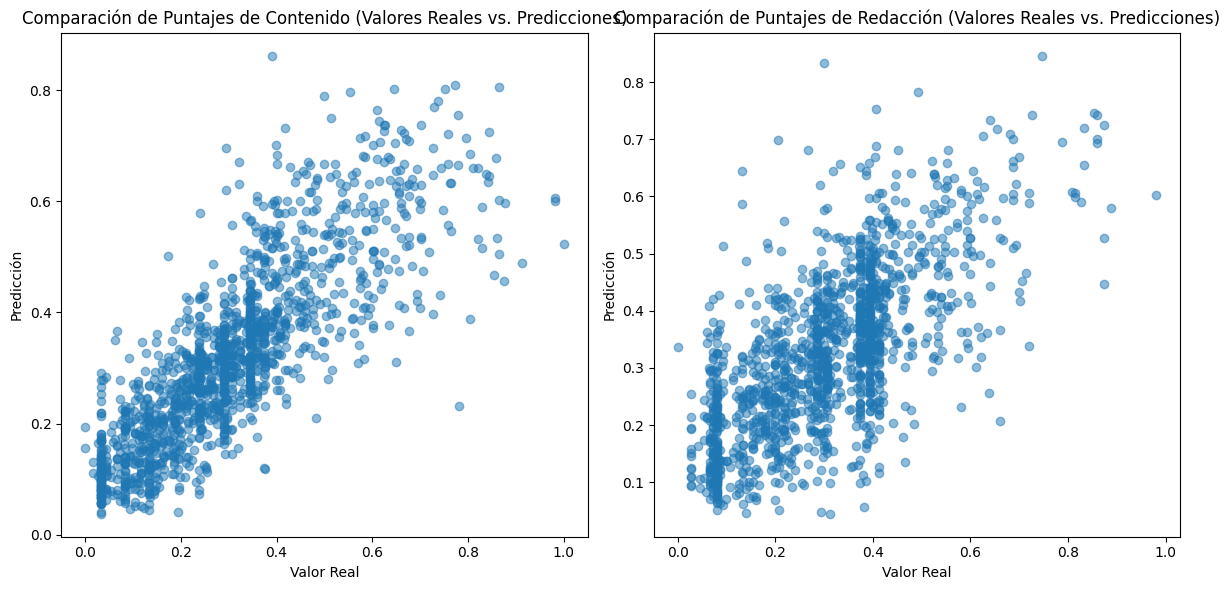

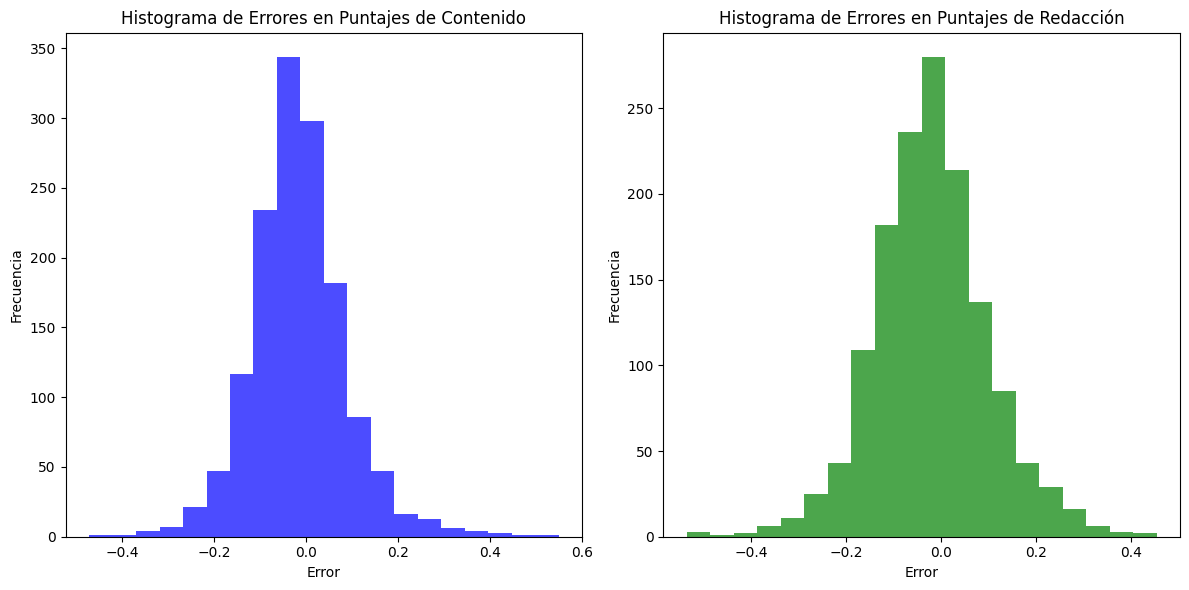

In [9]:
import matplotlib.pyplot as plt

# Supongamos que ya tienes el modelo entrenado y que has realizado predicciones en el conjunto de prueba
predicted_scores = model.predict(X_test)

# Obtener los valores reales del conjunto de prueba
actual_content = y_test['normalized_content']
actual_wording = y_test['normalized_wording']

# Crear un scatter plot para comparar las predicciones con los valores reales de contenido
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(actual_content, predicted_scores[:, 0], alpha=0.5)
plt.title('Comparación de Puntajes de Contenido (Valores Reales vs. Predicciones)')
plt.xlabel('Valor Real')
plt.ylabel('Predicción')

# Crear un scatter plot para comparar las predicciones con los valores reales de redacción
plt.subplot(1, 2, 2)
plt.scatter(actual_wording, predicted_scores[:, 1], alpha=0.5)
plt.title('Comparación de Puntajes de Redacción (Valores Reales vs. Predicciones)')
plt.xlabel('Valor Real')
plt.ylabel('Predicción')

plt.tight_layout()

# Crear histogramas de errores para contenido y redacción
error_content = actual_content - predicted_scores[:, 0]
error_wording = actual_wording - predicted_scores[:, 1]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(error_content, bins=20, color='blue', alpha=0.7)
plt.title('Histograma de Errores en Puntajes de Contenido')
plt.xlabel('Error')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
plt.hist(error_wording, bins=20, color='green', alpha=0.7)
plt.title('Histograma de Errores en Puntajes de Redacción')
plt.xlabel('Error')
plt.ylabel('Frecuencia')

plt.tight_layout()

plt.show()